## Imports, Data, Cleaning

Import libraries

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import KFold
import scipy.stats as stats
import seaborn as sns
import pingouin as pg

Read in data

In [16]:
pred_df = pd.read_csv("nsds_II_predictors_level1.csv")
outcome_df = pd.read_csv("nsds_II_outcomes_level1_AAK.csv")
matching = pd.read_excel("matching.xlsx")
ratings_m1_long = pd.read_excel("Ratings_m1.xlsx")
ratings_m2_long = pd.read_excel("Ratings_m2.xlsx")
ratings_w1_long = pd.read_excel("Ratings_w1.xlsx")
ratings_w2_long = pd.read_excel("Ratings_w2.xlsx")

Calculate actor and partner effect

In [3]:
# Aggregation
actor_effect = pd.Series(outcome_df.groupby("id")["general_raw"].apply(np.mean), name="ActorEffect")
partner_effect = pd.Series(outcome_df.groupby("partnerid")["general_raw"].apply(np.mean), name="PartnerEffect")

# Calculation of grand means
actor_grand_m = actor_effect.mean()
partner_grand_m = partner_effect.mean()

# Calculation of final score for each individual
actor_effect = actor_effect - actor_grand_m
partner_effect = partner_effect - partner_grand_m

# Combination of the two series into an outcome dataframe
# The two series have different length: 186 and 187 unique values.
# Through the inner join id 219 will be removed as the actor effect cannot be calculated for this person.
outcomes = pd.merge(actor_effect,partner_effect, right_index = True, left_index = True, how='inner')
outcomes.index.name='id'

Cleaning of the predictor dataframe

In [5]:
# Removal of columns that describe the characteristics of the partner
pattern = re.compile('.*par$')
columns_to_remove = [col for col in pred_df.columns if pattern.match(col)]
pred_df.drop(columns=columns_to_remove, inplace=True)

# Removal of duplicates in 'id' as values of other columns in these rows do not change per id
pred_df.drop_duplicates(subset=['id'], inplace=True)

# Change gender to integer
pred_df['gender_id'] = pred_df['gender_id'].apply(lambda x: 0 if x == "f" else 1)

# Take id as indices
pred_df.set_index("id", inplace=True)

# Removal of partnerid column
pred_df = pred_df.drop(pred_df.columns[0], axis=1)

Prepare the flirting data

In [12]:
def data_clean_prepare(df, rater):
    
    # Renaming rater
    rater_name1 = f"R_{rater}_1"
    rater_name2 = f"R_{rater}_2"
    df['Rater'].replace({rater_name1: 1, rater_name2: 2}, inplace=True)
    
    # Rename videos name
    df['Videos'] = df['Videos'].str[:-1]
    df['Videos'] = df['Videos'].str.replace('_', '')
    
    # Wide format
    wide_df = df.pivot_table(index='Videos', columns='Rater')
    
    # Imputer
    wide_df = wide_df.fillna(wide_df.median()).astype(int)
    
    # Calculate icc
    icc_f_gen = pg.intraclass_corr(data=df, targets='Videos', raters='Rater', ratings='F_gen', nan_policy='omit').iloc[5,2]
    icc_f_ag = pg.intraclass_corr(data=df, targets='Videos', raters='Rater', ratings='F_ag', nan_policy='omit').iloc[5,2]
    icc_f_com = pg.intraclass_corr(data=df, targets='Videos', raters='Rater', ratings='F_com', nan_policy='omit').iloc[5,2]
    icc_df = pd.DataFrame([[icc_f_gen, icc_f_ag, icc_f_com]], columns=["icc_f_gen", "icc_f_ag", "icc_f_com"])
    
    
    return wide_df, icc_df

In [17]:
ratings_m1_wide, m1_icc = data_clean_prepare(ratings_m1_long, "m1")
ratings_m2_wide, m2_icc = data_clean_prepare(ratings_m2_long, "m2")
ratings_w1_wide, w1_icc = data_clean_prepare(ratings_w1_long, "w1")
ratings_w2_wide, w2_icc = data_clean_prepare(ratings_w2_long, "w2")

In [18]:
# icc Df
icc_df = pd.concat([m1_icc, m2_icc, w1_icc, w2_icc], axis=0, keys=['m1', 'm2', 'w1', 'w2']).reset_index(level=1, drop=True)
icc_df

,icc_f_gen,icc_f_ag,icc_f_com
m1,0.437278,0.389656,0.378024
m2,0.572697,0.528170,0.438365
w1,0.508714,0.477013,0.534486
w2,0.649684,0.686326,0.665926


In [19]:
icc_df.mean()

icc_f_gen    0.542093
icc_f_ag     0.520291
icc_f_com    0.504200
dtype: float64

In [9]:
# Match video names with IDs - Further Data wrangling

## Connect m1 and m2
ratings_m = pd.concat([ratings_m1_wide, ratings_m2_wide])

## Connect w1 and w2
ratings_f = pd.concat([ratings_w1_wide, ratings_w2_wide])

## Aggregation for each of the three flirting variables by calculating mean between rater 1 and 2
ratings_m = ratings_m.groupby(level=0, axis=1).mean()
ratings_f = ratings_f.groupby(level=0, axis=1).mean()

## Split matching df in male and female
grouped = matching.groupby('gender')

## Access the separate groups as individual DataFrames
matching_f = grouped.get_group('f')
matching_m = grouped.get_group('m')

## Connect ratings with matching keys
matching_f_merge = matching_f.merge(ratings_m, left_on='datecode', right_index=True)
matching_m_merge = matching_m.merge(ratings_f, left_on='datecode', right_index=True)

## Merge the two dfs again
matching_flirting = pd.concat([matching_f_merge, matching_m_merge])

In [10]:
# Aggregation method of flirting variables similar to actor and partner effect calculcation
flirt_gen = pd.Series(matching_flirting.groupby("user_id")["F_gen"].apply(np.mean), name="F_gen")
flirt_ag = pd.Series(matching_flirting.groupby("user_id")["F_ag"].apply(np.mean), name="F_ag")
flirt_com = pd.Series(matching_flirting.groupby("user_id")["F_com"].apply(np.mean), name="F_com")

# Aggregation to get raw scores for each id
flirt_gen_grand_m = flirt_gen.mean()
flirt_ag_grand_m = flirt_ag.mean()
flirt_com_grand_m = flirt_com.mean()

# Calculate final score for each individual
flirt_gen = flirt_gen - flirt_gen_grand_m
flirt_ag = flirt_ag - flirt_ag_grand_m
flirt_com = flirt_com - flirt_com_grand_m

In [11]:
# Add Flirting variables to predictor df
pred_df_flirt = pd.concat([pred_df, flirt_gen, flirt_ag, flirt_com], axis=1)

In [12]:
# NA check
pred_df_flirt[pred_df_flirt.isna().any(axis=1)]

# ID 93 and ID 243 do not have any videos available for rating, Imputer will provide values.
# ID 219 is not included, there are ratings available, but there is no data from the personality questionnaire for this person, so also removal in the predictor df.
pred_df_flirt = pred_df_flirt.drop(219)

Create a predictor dataframe without flirting

In [13]:
columns_to_exclude = ["F_gen", "F_ag", "F_com"]
pred_df_noflirt = pred_df_flirt.drop(columns=columns_to_exclude)

Create a dataframe with all predictors and outcomes

In [14]:
df = pred_df_flirt.join(outcomes)
df.index.name='id'

## Functions and Models

### Imputer for missing values

In [15]:
class Imputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy):
        self.strategy = strategy
        
    def fit(self, X, y=None):
        self.imputer = SimpleImputer(strategy = self.strategy).fit(X)
        return self
    
    def transform(self, X, y=None):
        X_transformed = self.imputer.transform(X)
        return X_transformed

### Scaler

In [16]:
class Scaler(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.scaler = StandardScaler().fit(X)
        return self
    
    def transform(self, X, y=None):
        X_transformed = self.scaler.transform(X)
        return X_transformed

### Pipeline

In [17]:
pipeline = Pipeline(steps = [("SC", Scaler()),
                                 ("IM", Imputer(strategy = "mean")),
                                  ("RF", RandomForestRegressor(random_state = 16))])

### Parameter dictionary

In [18]:
param_dict = {"RF__n_estimators": [200, 400, 550, 700, 850, 1000],
                  "RF__max_depth": [3, 4, 5, 6, 7, 8, 9, 10],
                  "RF__max_features": [2, 4, 5, 8, 10],
                  "RF__min_samples_split" : [2, 5, 10],
                  "RF__min_samples_leaf" : [1, 2, 4]}

### RF with nested CV without FI

In [19]:
# Method that executes a random forest with nested cross-validation and imputer + scaling

def rf_cv_impscale(X, y):
    
    rndCV = RandomizedSearchCV(estimator = pipeline, param_distributions = param_dict, n_iter = 8, scoring = "explained_variance", n_jobs = -1, cv = 10)
    cv_rf = cross_val_score(estimator = rndCV, X = X, y = y, scoring = "explained_variance", cv = 5, n_jobs = -1)
    print(cv_rf.mean())
    return cv_rf

### RF with nested CV with FI

In [20]:
def cross_val_features(X,y,effect):
    
    # Creating a basic frame for a DF that displays Permutation Importances from all folds in the outer CV
    feature_importance_df = pd.Series(X.columns).rename("Predictor")
    feature_importance_df = pd.DataFrame(feature_importance_df) 
    
    if (effect=='Actor'):
        y = y['ActorEffect']
    elif (effect=='Partner'):
        y = y['PartnerEffect']
        
    # Cross Validation
    # Outer CV
    det_coeff = []
    i = 1
    outer_cv = KFold( n_splits = 5, random_state = 42, shuffle= True)
    inner_cv = KFold(n_splits = 10, random_state = 42, shuffle= True)
    for train_index, test_index in outer_cv.split(X,y):
    # Repeat for all outer folds
        X_train = X.iloc[train_index,:]
        X_test = X.iloc[test_index, :]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]
        
        # Inner CV
        ## Split into Training and Test
        ## For all combinations of parameter sets calculate Random Forest model
        rndCV = RandomizedSearchCV(estimator = pipeline, param_distributions = param_dict, n_iter = 8, scoring = "r2", n_jobs = -1, cv = inner_cv)

        search = rndCV.fit(X_train,y_train)
        ## Give the parameter set that has performed best on average over all inner folds to outer cv.

        # Outer CV
        ## Train Random Forest model with the parameter set of the Inner CV on the training set of the current outer fold
        pipeline.set_params(**search.best_params_)
        pipeline.fit(X_train, y_train)
        
        ## test on test set
        det_coeff.append(round(pipeline.score(X_test, y_test),2))

        ## Permutation Importance extraction
        perm_importance = permutation_importance(pipeline, X_train, y_train, scoring="explained_variance", n_repeats=10)
        importances_mean = pd.Series(perm_importance.importances_mean).rename(f"Importance Mean Outer Fold {i}")
        importances_std = pd.Series(perm_importance.importances_std).rename(f"Importance Std Outer Fold {i}")
        feature_importance_df = pd.concat([feature_importance_df, importances_mean, importances_std], axis=1)
        i = i+1
        #feature_importance_df.sort_values(by=[f'Importance Mean Outer Fold {i}'],ascending=False)
    return feature_importance_df, det_coeff

### Extraction of predictors exceeding cutoff FI value

In [21]:
def perm_importance_cutoff_10f(feature_imp_df):
    # Rename
    feature_imp_df = rename_var(feature_imp_df.copy())
    
    # Actual function
    feature_dict = {}
    feature_dict_values = {}
    for i in range(5):
        top_10 = feature_imp_df.nlargest(10, f'Importance Mean Outer Fold {i+1}')
        
        for index, row in top_10.iterrows():
            pred = row['Predictor']
            value = row[f'Importance Mean Outer Fold {i+1}']
            if pred in feature_dict:
                feature_dict[pred] += 1
                feature_dict_values[pred].append(value)
            else:
                feature_dict[pred] = 1
                feature_dict_values.setdefault(pred, []).append(value)

    return feature_dict, feature_dict_values

### Rename Variables for Visualization

In [22]:
def rename_var(df):
    exceptions = ['F_gen', 'F_ag', 'F_com', 'att_rating_act']
    # Remove underscore and everything after it, except for exceptions
    df['Predictor'] = df['Predictor'].apply(lambda x: x if x in exceptions else re.sub(r'_.+', '', x))
    return df

## Research questions

### 1. Flirting Vs No-Flirting

#### Actor Effect

In [23]:
# Without flirting
actor_noflirt = rf_cv_impscale(pred_df_noflirt, df["ActorEffect"])
actor_noflirt

0.00202999308162366


array([-0.04309322, -0.05815531,  0.02753709,  0.03347218,  0.05038922])

In [24]:
# With  flirting
actor_flirt = rf_cv_impscale(pred_df_flirt, df["ActorEffect"])
actor_flirt

0.004195638275773827


array([-0.0490225 , -0.04699988,  0.05284011,  0.03330884,  0.03085162])

#### Partner Effect

In [26]:
# Without flirting
partner_noflirt = rf_cv_impscale(pred_df_noflirt, df["PartnerEffect"])
partner_noflirt

0.11289264286575192


array([ 0.23023491, -0.16889789,  0.13424913,  0.24184503,  0.12703204])

In [27]:
# With  flirting
partner_flirt = rf_cv_impscale(pred_df_flirt, df["PartnerEffect"])
partner_flirt

0.14132631936306891


array([ 0.22590063, -0.11626692,  0.15674983,  0.25475854,  0.18548952])

### 2. Male Vs Female

Create Gender separate pred_df 

In [29]:
pred_df_female_flirt = pred_df_flirt[pred_df_flirt['gender_id'] == 0]
pred_df_female_noflirt = pred_df_noflirt[pred_df_noflirt['gender_id'] == 0]
df_female = df[df['gender_id'] == 0]
pred_df_male_flirt = pred_df_flirt[pred_df_flirt['gender_id'] == 1]
pred_df_male_noflirt = pred_df_noflirt[pred_df_noflirt['gender_id'] == 1]
df_male = df[df['gender_id'] == 1]

#### Actor Effect

In [30]:
# Male
# without Flirting
fi_actor_male_noflirt, det_actor_male_noflirt = cross_val_features(pred_df_male_noflirt, df_male, 'Actor')
det_actor_male_noflirt

[0.06, 0.14, 0.05, 0.0, -0.07]

In [31]:
np.mean(det_actor_male_noflirt)

0.036

In [32]:
# Male
# with Flirting
fi_actor_male_flirt, det_actor_male_flirt = cross_val_features(pred_df_male_flirt, df_male, 'Actor')
det_actor_male_flirt

[0.08, 0.16, 0.1, 0.02, -0.07]

In [33]:
np.mean(det_actor_male_flirt)

0.057999999999999996

In [34]:
# Women
# without Flirting
fi_actor_female_noflirt, det_actor_female_noflirt = cross_val_features(pred_df_female_noflirt, df_female, 'Actor')
det_actor_female_noflirt

[-0.21, -0.19, -0.29, -0.06, -0.12]

In [35]:
np.mean(det_actor_female_noflirt)

-0.174

In [36]:
# Women
# with Flirting
fi_actor_female_flirt, det_actor_female_flirt = cross_val_features(pred_df_female_flirt, df_female, 'Actor')
det_actor_female_flirt

[-0.24, -0.21, -0.22, -0.03, -0.1]

In [37]:
np.mean(det_actor_female_flirt)

-0.15999999999999998

#### Partner Effect

In [40]:
# Men
# without Flirting
fi_partner_male_noflirt, det_partner_male_noflirt = cross_val_features(pred_df_male_noflirt, df_male, 'Partner')
det_partner_male_noflirt

[-0.03, 0.13, -0.07, 0.1, 0.28]

In [41]:
np.mean(det_partner_male_noflirt)

0.082

In [42]:
# Men
# with Flirting
fi_partner_male_flirt, det_partner_male_flirt = cross_val_features(pred_df_male_flirt, df_male, 'Partner')
det_partner_male_flirt

[0.04, 0.13, 0.02, 0.09, 0.26]

In [43]:
np.mean(det_partner_male_flirt)

0.10800000000000001

In [44]:
# Women
# without Flirting
fi_partner_female_noflirt, det_partner_female_noflirt = cross_val_features(pred_df_female_noflirt, df_female, 'Partner')
det_partner_female_noflirt

[0.17, -0.08, 0.07, -0.06, 0.01]

In [45]:
np.mean(det_partner_female_noflirt)

0.022000000000000006

In [46]:
# Women
# with Flirting
fi_partner_female_flirt, det_partner_female_flirt = cross_val_features(pred_df_female_flirt, df_female, 'Partner')
det_partner_female_flirt

[0.15, -0.09, 0.1, -0.04, 0.03]

In [47]:
np.mean(det_partner_female_flirt)

0.03

### 3. Feature importances

#### Actor Effect

In [50]:
features_actor_male_noflirt, fvalues_actor_male_noflirt = perm_importance_cutoff_10f(fi_actor_male_noflirt)

In [51]:
features_actor_male_flirt, fvalues_actor_male_flirt = perm_importance_cutoff_10f(fi_actor_male_flirt)

In [52]:
features_actor_female_noflirt, fvalues_actor_female_noflirt = perm_importance_cutoff_10f(fi_actor_female_noflirt)

In [53]:
features_actor_female_flirt, fvalues_actor_female_flirt = perm_importance_cutoff_10f(fi_actor_female_flirt)

##### Visualization

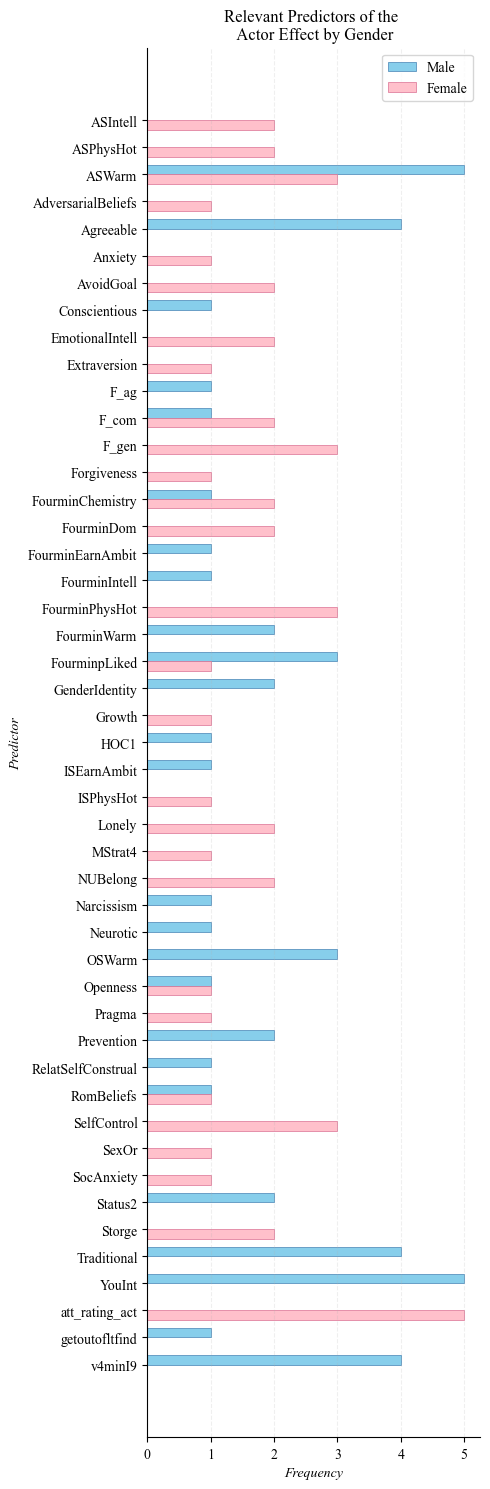

In [54]:
keys = sorted(list(set(features_actor_male_flirt.keys()).union(features_actor_female_flirt.keys())), reverse=True)
values1 = [features_actor_male_flirt.get(key, 0.) for key in keys]
values2 = [features_actor_female_flirt.get(key, 0) for key in keys]
plt.rcParams["font.family"] = "Times New Roman"
# Generate the x-positions for the bars
y_pos = np.arange(len(keys))

# Set the width of each bar
bar_height = 0.35

# Figure size
plt.figure(figsize=(5, 15))

# Create a grouped bar chart
plt.barh(y_pos + bar_height/2, values1, height=bar_height, label='Male', color='skyblue', edgecolor='steelblue', linewidth=0.5)
plt.barh(y_pos - bar_height/2, values2, height=bar_height, label='Female', color='pink', edgecolor='palevioletred', linewidth=0.5)

# Rotate y-axis labels for better readability
plt.yticks(y_pos, keys, rotation=0, ha='right')

# Set labels and title
plt.ylabel('Predictor',fontstyle='italic')
plt.xlabel('Frequency',fontstyle='italic')
plt.title('Relevant Predictors of the \n Actor Effect by Gender')

# Customize gridlines
plt.grid(axis='x', linestyle='--', alpha=0.2)

# Add a legend
plt.legend(loc='upper right')

# Set x-axis ticks
plt.xticks(np.arange(6))

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjust spacing
plt.tight_layout()
plt.savefig('bar_plot.png', dpi=300)

# Display the plot
plt.show()

#### Partner Effect

In [55]:
features_partner_male_noflirt, fvalues_partner_male_noflirt = perm_importance_cutoff_10f(fi_partner_male_noflirt)

In [56]:
features_partner_male_flirt, fvalues_partner_male_flirt = perm_importance_cutoff_10f(fi_partner_male_flirt)

In [57]:
features_partner_female_noflirt, fvalues_partner_female_noflirt = perm_importance_cutoff_10f(fi_partner_female_noflirt)

In [58]:
features_partner_female_flirt, fvalues_partner_female_flirt = perm_importance_cutoff_10f(fi_partner_female_flirt)

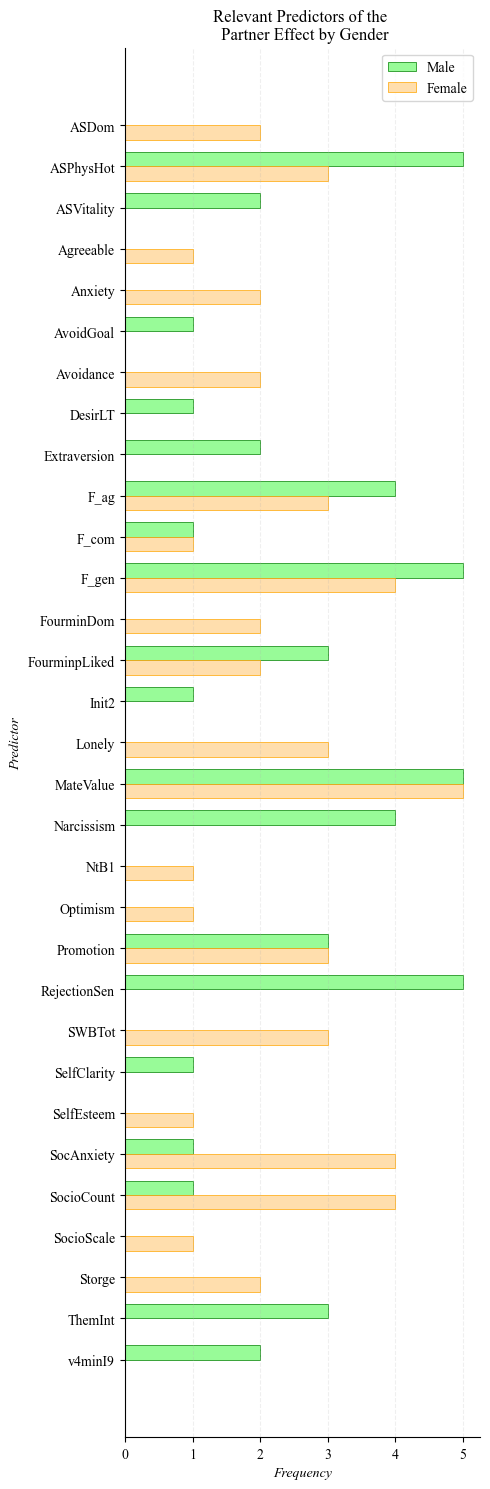

In [59]:
keys = sorted(list(set(features_partner_male_flirt.keys()).union(features_partner_female_flirt.keys())), reverse=True)
values1 = [features_partner_male_flirt.get(key, 0.) for key in keys]
values2 = [features_partner_female_flirt.get(key, 0) for key in keys]
plt.rcParams["font.family"] = "Times New Roman"

# Generate the x-positions for the bars
y_pos = np.arange(len(keys))

# Set the width of each bar
bar_height = 0.35

# Figure size
plt.figure(figsize=(5, 15))

# Create a grouped bar chart
plt.barh(y_pos + bar_height/2, values1, height=bar_height, label='Male', color='palegreen', edgecolor='green', linewidth=0.5)
plt.barh(y_pos - bar_height/2, values2, height=bar_height, label='Female', color='navajowhite', edgecolor='orange', linewidth=0.5)

# Rotate y-axis labels for better readability
plt.yticks(y_pos, keys, rotation=0, ha='right')

# Set labels and title
plt.ylabel('Predictor',fontstyle='italic')
plt.xlabel('Frequency',fontstyle='italic')
plt.title('Relevant Predictors of the \n Partner Effect by Gender')

# Customize gridlines
plt.grid(axis='x', linestyle='--', alpha=0.2)

# Add a legend
plt.legend(loc='upper right')

# Set x-axis ticks
plt.xticks(np.arange(6))

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjust spacing
plt.tight_layout()
plt.savefig('bar_plot2.png', dpi=300)
# Display the plot
plt.show()

#### Visualization FI Values

In [60]:
actor_male = pd.Series(fvalues_actor_male_flirt).rename("Actor Male")
actor_female = pd.Series(fvalues_actor_female_flirt).rename("Actor Female")
partner_male = pd.Series(fvalues_partner_male_flirt).rename("Partner Male")
partner_female = pd.Series(fvalues_partner_female_flirt).rename("Partner Female")
fvalues_all = pd.concat([actor_male, actor_female, partner_male, partner_female], axis=1)
fvalues_all['Predictor'] = fvalues_all.index

In [61]:
# Melt the DataFrame - Wide to Long format
fvalues_all = fvalues_all.melt(id_vars='Predictor', var_name='Effect', value_name='Value')
fvalues_all = fvalues_all.dropna()

# Explode the 'value' column to create separate rows for each value in the list
df_exploded = fvalues_all.explode('Value')

# Reset the index
df_exploded = df_exploded.reset_index(drop=True)

# Sort
sorted_df = df_exploded.sort_values('Predictor')


In [66]:
# Get unique values in the "Predictor" column
unique_predictors = sorted_df["Predictor"].unique()

# Calculate the number of subsets
num_subsets = len(unique_predictors) // 13 + 1

# Split the unique predictors into subsets
subsets = [unique_predictors[i:i+13] for i in range(0, len(unique_predictors), 13)]

# Split the DataFrame into subsets based on the "Predictor" column
subset_dfs = []
for subset in subsets:
    subset_df = sorted_df[sorted_df["Predictor"].isin(subset)]
    subset_dfs.append(subset_df)


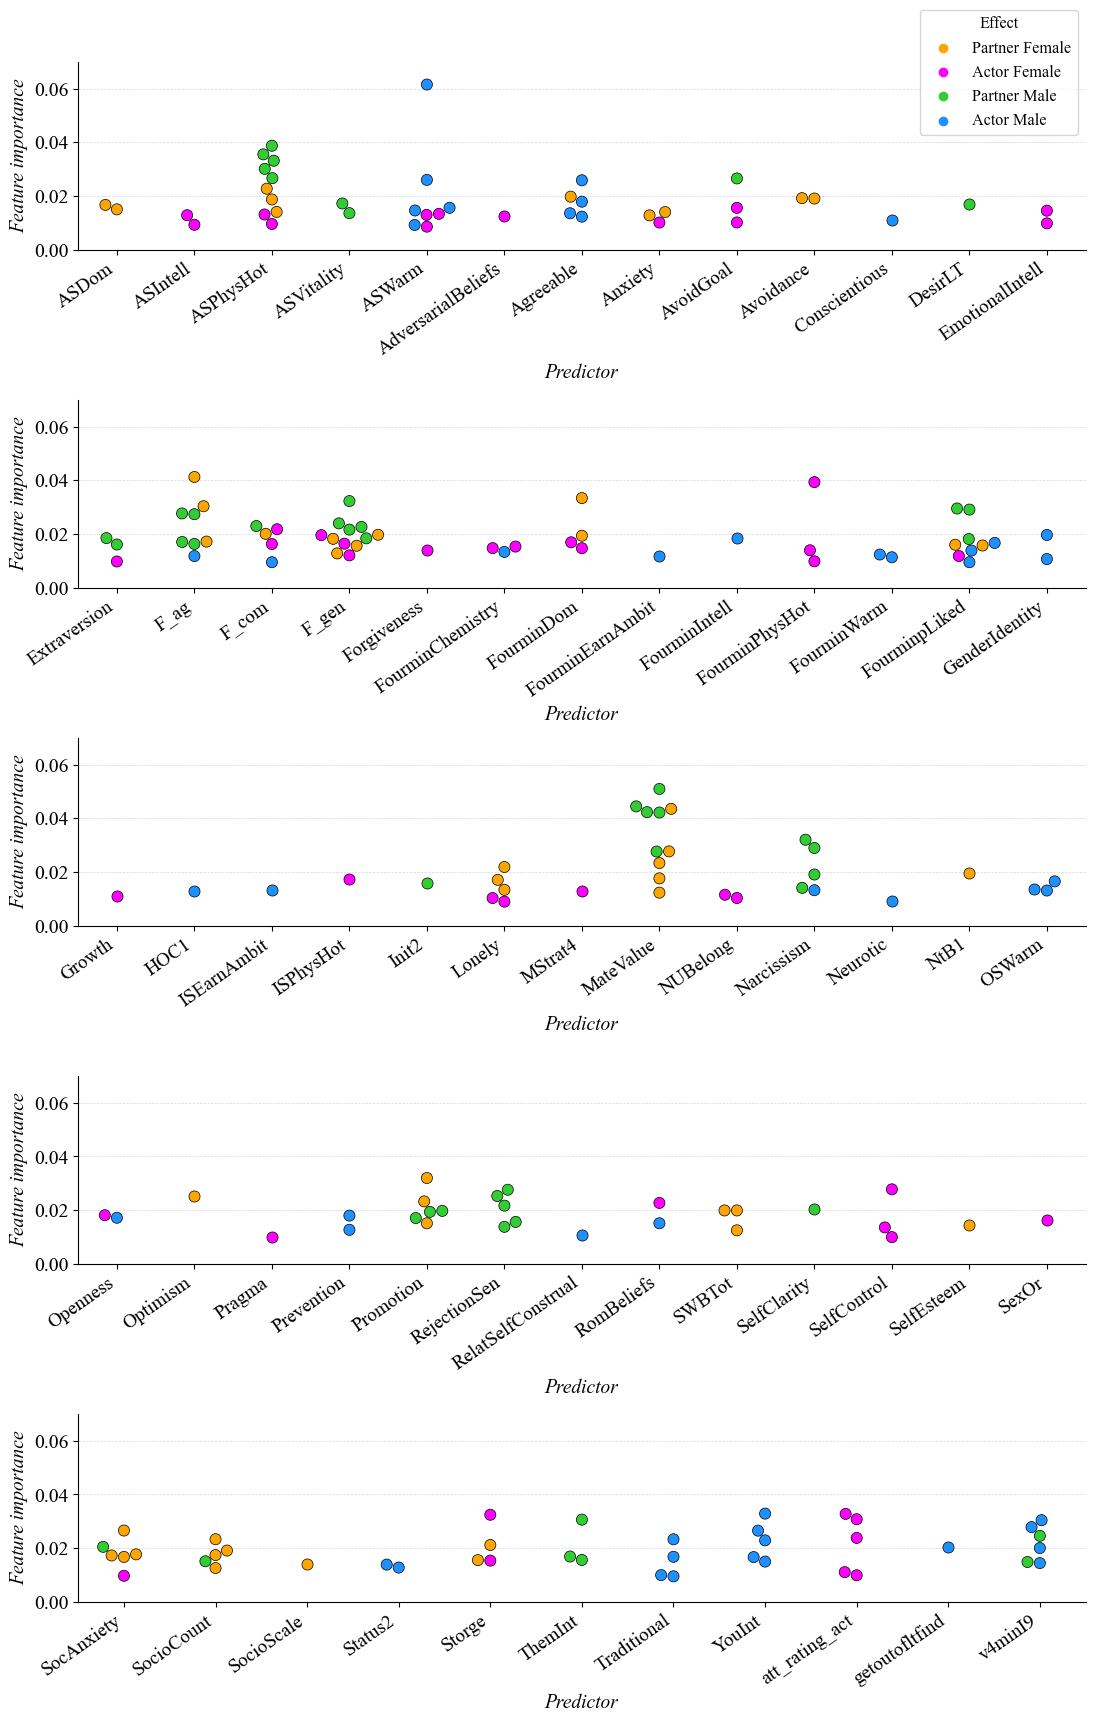

In [97]:
# Set global font properties
plt.rcParams["font.size"] = 14
plt.rcParams["font.family"] = "Times New Roman"

# Create subplots
fig, axes = plt.subplots(5, 1, figsize=(13, 20), gridspec_kw={'hspace': 0.8})

# Define custom colors for the swarmplot
colors = ['dodgerblue', 'magenta', 'limegreen', 'orange']

# Define custom legend labels and order
legend_labels = ['Actor Male', 'Actor Female', 'Partner Male', 'Partner Female']

hue_to_color = {
    'Actor Male': colors[0],
    'Actor Female': colors[1],
    'Partner Male': colors[2],
    'Partner Female': colors[3]
}

# Iterate over the subplots
for i, ax in enumerate(axes):
    
    # Create the swarmplot for the current subplot
    s = sns.swarmplot(x="Predictor", y="Value", data=subset_dfs[i], hue='Effect', palette=hue_to_color, ax=ax, edgecolor='black',
                  linewidth=0.5, size=8)

    # Set subplot title and axis labels
    ax.set_xlabel("Predictor", fontstyle='italic')
    ax.set_ylabel("Feature importance", fontstyle='italic')
    
    # Add gridlines
    ax.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.5)

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Adjust x-axis label rotation and spacing
    ax.set_xticks(range(len(subset_dfs[i]['Predictor'].unique())))
    ax.set_xticklabels(subset_dfs[i]['Predictor'].unique(), rotation=35, ha='right')

    # Set y-axis limits
    ax.set_ylim(0, 0.07)
    
    # Remove single legends
    ax.legend().set_visible(False) 
    
# Move the legend to the upper right
handles, labels = axes[0].get_legend_handles_labels()
legend = fig.legend(handles, labels, title="Effect", title_fontsize='small', loc='upper right',
                    bbox_to_anchor=(0.9,0.91), fontsize='small')
                                    
# Save
plt.savefig('swarmplot.png', dpi=300)

# Show the plot
plt.show()